In [1]:
# enter at past 10 candles 1h rsi 35 oversold, rsi_length 18, 15m cross k > d, 4h ema1 > ema3
# exit at 1h rsi 74 overbought
# stop loss 2 atr
# start time - 1609492611000, 1641028611000, 1672564611000 (2021, 2022, 2023)


In [2]:
# ! conda install -c conda-forge ta --yes

In [3]:
import requests
import pandas as pd
import pandas_ta as p_ta
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time

In [4]:
# dataframes = {}
def create_raw(symbol, interval_arr, start_time, end_time, step):
    
    url = "https://api.binance.com/api/v3/klines"
    
    for interval in interval_arr:

        raw_df = pd.DataFrame()
        
        for timestamp in range(start_time, end_time, step):
            params = {"symbol": symbol_C,
                      "interval": interval,
                      "startTime": timestamp,
                      "endTime": timestamp + step}
            response = requests.get(url, params=params).json()
            out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                                   "Volume", "Close_Time", "Quote asset volume",
                                                   "Number of trades", "Taker buy base asset volume",
                                                   "Taker buy quote asset volume", "Ignore"])
            raw_df = pd.concat([raw_df, out], axis = 0)

        raw_df = raw_df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
#         dataframes[f"df_{interval}"] = raw_df
        raw_df.to_hdf(f'klines_{symbol}_{interval}.h5', key='df', mode='w')
        print(f"Created {symbol}_{interval}")

In [5]:
interval_arr = ['15m', '1h', '4h']
start_time_arr = [1651366861000]
ema_arr = [8, 18, 38]

In [6]:
timezone = 8
symbol = 'ftmusdt'
symbol_C = symbol.upper()
interval = '15m'

start_time = 1651366861000
end_time = round(time.time() * 1000)

# step between timestamps in milliseconds
step = 60000 * 3600

In [7]:
loop_start_time = time.time()
create_raw(symbol, interval_arr, min(start_time_arr), end_time, step)
loop_end_time = time.time()
print("Time taken to execute for loop:", loop_end_time - loop_start_time, "seconds")
# print(dataframes)

Created ftmusdt_15m
Created ftmusdt_1h
Created ftmusdt_4h
Time taken to execute for loop: 61.59399175643921 seconds


In [8]:
h5 = pd.read_hdf(f'klines_{symbol}_{interval_arr[0]}.h5', key='df')
print(h5.tail(1))
print(len(h5))

       Close_Time        Open       Close        High         Low  \
97  1685367899999  0.33910000  0.33830000  0.33920000  0.33820000   

             Volume  
97  184856.00000000  
37773


In [9]:
klines_cache = {}

def get_klines(symbol, interval, start_time, end_time):
    if (symbol, interval) not in klines_cache:
        klines_cache[(symbol, interval)] = pd.read_hdf(f'klines_{symbol}_{interval}.h5', key='df')

    df = klines_cache[(symbol, interval)].query(f"Close_Time >= {start_time} and Close_Time <= {end_time}")

    df = df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']].astype(float)
    df = df.set_index('Close_Time')
#     df = df.reset_index(drop=True)

    df.index = pd.to_datetime(df.index, unit='ms') + pd.Timedelta(hours=timezone)
    df = df[~df.index.duplicated(keep='first')]

    return df

In [10]:
def time_format(timezone):
#     df['Close_Time'] = pd.to_datetime(df['Close_Time'], unit='ms') + pd.Timedelta(hours=timezone)
#     df['Close_Time'] = df['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    df.index = pd.to_datetime(df.index, unit='ms') + pd.Timedelta(hours=timezone)
    df.index = df.index.strftime('%Y-%m-%d %H:%M:%S')

In [11]:
bb_int = 30
bb_dev = 2
rsi_int = 18

In [12]:
df = get_klines(symbol, interval_arr[0], start_time, end_time).copy()
df = df.astype(float).round(4)

for interval in interval_arr:
    raw_df = get_klines(symbol, interval, start_time, end_time)
    
    # ema
    for ema in ema_arr:
        column_name = f'ema_{ema}_{interval}'
        df[column_name] = ta.trend.ema_indicator(raw_df.Close, window=ema)
    
    # bb
    bb = ta.volatility.BollingerBands(raw_df.Close, window=bb_int, window_dev=bb_dev)
    df[f'bb_u_{interval}'] = bb.bollinger_hband()
    df[f'bb_m_{interval}'] = bb.bollinger_mavg()
    df[f'bb_l_{interval}'] = bb.bollinger_lband()        

    # rsi
    rsi = ta.momentum.RSIIndicator(raw_df.Close, window = rsi_int)
    df[f'rsi_{interval}'] = rsi.rsi()
    
    # atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# reset index and set current index as a column
df = df.reset_index()

# set new index with integers
df = df.set_index(pd.RangeIndex(len(df)))

# time_format(timezone)
df['Close_Time'] = df['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')

print(df)
df.to_csv('df.csv')

                Close_Time    Open   Close    High     Low     Volume  \
0      2022-05-01 09:29:59  0.6792  0.6696  0.6829  0.6685  2632944.0   
1      2022-05-01 09:44:59  0.6694  0.6946  0.7007  0.6548  9171613.0   
2      2022-05-01 09:59:59  0.6944  0.6932  0.7078  0.6903  7659398.0   
3      2022-05-01 10:14:59  0.6933  0.7008  0.7020  0.6893  3100687.0   
4      2022-05-01 10:29:59  0.7007  0.6906  0.7021  0.6903  2993024.0   
...                    ...     ...     ...     ...     ...        ...   
37767  2023-05-29 20:29:59  0.3396  0.3398  0.3401  0.3388   753507.0   
37768  2023-05-29 20:44:59  0.3396  0.3385  0.3396  0.3385   723414.0   
37769  2023-05-29 20:59:59  0.3386  0.3389  0.3393  0.3381   889881.0   
37770  2023-05-29 21:14:59  0.3390  0.3399  0.3402  0.3390   744421.0   
37771  2023-05-29 21:29:59  0.3399  0.3391  0.3401  0.3390   410736.0   

       ema_8_15m  ema_18_15m  ema_38_15m  bb_u_15m  ...   bb_m_1h   bb_l_1h  \
0            NaN         NaN         NaN    

In [13]:
# enter at past 10 candles 1h rsi 35 oversold, rsi_length 18, 15m cross k > d, 4h ema1 > ema3
# exit at 1h rsi 74 overbought
# stop loss 2 atr

In [14]:
rsi_up = 72
rsi_low = 40
kd_dir = 'Up'

In [15]:
def check_cross(df, kd_dir):
    up = df['slow_k'] > df['slow_d']
    down = df['slow_k'] < df['slow_d']
    if kd_dir == 'Up':
        return up.diff() & up
    if kd_dir == 'Any':
        return up.diff()
    if kd_dir == 'Down':
        return down.diff() & down


def indicators(df, kd_dir):

# # ema
#     for i in (8, 18, 38):
#         df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# # bband
#     bb_int = 30
#     bb_dev = 2
#     bb = ta.volatility.BollingerBands(df['Close'], window=bb_int, window_dev=bb_dev)
#     df['bb_u'] = bb.bollinger_hband()
#     df['bb_m'] = bb.bollinger_mavg()
#     df['bb_l'] = bb.bollinger_lband()        
        
# # atr
#     df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# # rsi
#     rsi_int = 14
#     df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kd_df = pd.DataFrame()
    kd_df[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kd_df[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kd_df[str(kd_int) + '-Low'])*100/(kd_df[str(kd_int) + '-High'] - kd_df[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
# kd cross
    df['kd_cross'] = check_cross(df, kd_dir)

In [16]:
indicators(df, kd_dir)

In [17]:
df = df.replace('', np.nan)
df['ema_8_4h'] = df['ema_8_4h'].interpolate()
df['ema_38_4h'] = df['ema_38_4h'].interpolate()
df['rsi_1h'] = df['rsi_1h'].interpolate()

In [18]:
def conditions(df):
    # enter at past 10 candles 1h rsi 35 oversold, rsi_length 18, 15m cross k > d, 4h ema1 > ema3
    # exit at 1h rsi 74 overbought
    # stop loss 2 atr
    
    df['c1'] = False
    for i, row in df.iterrows():
        if i >= 10:
            if (df.loc[i-10:i-1, 'rsi_1h'] < rsi_low).any():
                df.loc[i, 'c1'] = True
                
        df['c2'] = df['kd_cross']
        
        df['c3'] = df[f'ema_{ema_arr[0]}_4h'] >= df[f'ema_{ema_arr[2]}_4h']
        
        df['c4'] = df[f'ema_{ema_arr[0]}_4h'] >= df[f'ema_{ema_arr[1]}_4h']



    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True

#     print(df)

    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
    
    df.to_csv('df.csv')

    return df

In [19]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8_15m,ema_18_15m,ema_38_15m,bb_u_15m,...,rsi_4h,slow_k,slow_d,kd_cross,c1,c2,c3,c4,signal,openbuy
0,2022-05-01 09:29:59,0.6792,0.6696,0.6829,0.6685,2632944.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,False,False,False,False,False
1,2022-05-01 09:44:59,0.6694,0.6946,0.7007,0.6548,9171613.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,False,False,False,False,False
2,2022-05-01 09:59:59,0.6944,0.6932,0.7078,0.6903,7659398.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,False,False,False,False,False
3,2022-05-01 10:14:59,0.6933,0.7008,0.7020,0.6893,3100687.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,False,False,False,False,False
4,2022-05-01 10:29:59,0.7007,0.6906,0.7021,0.6903,2993024.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37767,2023-05-29 20:29:59,0.3396,0.3398,0.3401,0.3388,753507.0,0.339793,0.340164,0.341139,0.343097,...,NaN,70.212766,73.758865,False,False,False,False,False,False,False
37768,2023-05-29 20:44:59,0.3396,0.3385,0.3396,0.3385,723414.0,0.339506,0.339989,0.341004,0.342968,...,NaN,42.553191,59.574468,False,False,False,False,False,False,False
37769,2023-05-29 20:59:59,0.3386,0.3389,0.3393,0.3381,889881.0,0.339371,0.339874,0.340896,0.342810,...,NaN,51.063830,54.609929,False,False,False,False,False,False,False
37770,2023-05-29 21:14:59,0.3390,0.3399,0.3402,0.3390,744421.0,0.339489,0.339877,0.340845,0.342664,...,NaN,72.340426,55.319149,True,False,True,False,False,False,False


In [20]:
sl_atr = 5

In [21]:
entry_df = conditions(df).copy()

in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']


for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'openbuy'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] - sl_atr * atr_val.shift(1).at[index]
#         entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] + tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
#         take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and (entry_df.at[index, 'Close'] <= stop_loss):
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position == True and (entry_df.at[index, 'rsi_1h'] >= rsi_up):
        entry_df.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
#         take_profit = np.nan
        entry_df.at[index, 'take_profit'] = close_val.at[index]
        
entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['openbuy'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Sell') |
              (entry_df['position'] == 'Stop')]

print(entry_df)

                Close_Time    Open   Close    High     Low     Volume  \
2250   2022-05-24 19:59:59  0.4202  0.4195  0.4209  0.4161  2097566.0   
2251   2022-05-24 20:14:59  0.4195  0.4152  0.4216  0.4148  1575731.0   
2417   2022-05-26 13:44:59  0.3925  0.3842  0.3932  0.3810  7621057.0   
6730   2022-07-10 11:59:59  0.2715  0.2719  0.2726  0.2714   279080.0   
6731   2022-07-10 12:14:59  0.2718  0.2708  0.2721  0.2706   605059.0   
6812   2022-07-11 08:29:59  0.2657  0.2622  0.2660  0.2619  2190157.0   
8170   2022-07-25 11:59:59  0.3173  0.3192  0.3197  0.3169  2409502.0   
8171   2022-07-25 12:14:59  0.3191  0.3210  0.3211  0.3170  2457885.0   
8301   2022-07-26 20:44:59  0.2979  0.2962  0.2982  0.2957  1291640.0   
10154  2022-08-15 03:59:59  0.3866  0.3872  0.3880  0.3863   794148.0   
10155  2022-08-15 04:14:59  0.3872  0.3880  0.3881  0.3860   350506.0   
10249  2022-08-16 03:44:59  0.3759  0.3736  0.3759  0.3723  2435893.0   
20282  2022-11-28 15:59:59  0.1836  0.1840  0.1841 

In [22]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Sell') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1000

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
#             pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[index, 'take_profit']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            pos.at[index, 'exit_p'] = pos.at[index, 'Close']
#             for i in range(index -1, -1, -1):
#                 if pos.at[i, 'position'] == 'Buy':
#                     pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
#                 break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee


# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算獲利/虧損次數
agg_amts = []

for i in range(len(pos) - 1, -1, -1):

    if pos.loc[i, 'position'] in ['Stop', 'Sell']:
        
        # look out for the + sign
        total_amt = pos.loc[i, 'amt'] + np.absolute(pos.loc[i, 'amt']) * fee
        
        # iterate backwards from the current row until reaching another 'Stop' or 'Sell'
        # watch out for the + in total_amt += trading_fee
        j = i - 1
        while j >= 0 and pos.loc[j, 'position'] not in ['Stop', 'Sell']:
            total_amt += pos.loc[j, 'amt']
            trading_fee = np.absolute(pos.loc[j, 'amt']) * fee
            total_amt += trading_fee
            j -= 1
        
        # add the aggregated amount to the list
        agg_amts.append(total_amt)

agg_amts.reverse()


# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():
    
    if row['position'] == 'Buy':
        
        consec_entry += 1
        position_amt_sum += row['amt']
        
    elif row['position'] in ['Sell', 'Stop']:
        
        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum
            
        position_amt_sum += row['amt']
        
        if -position_amt_sum > max_profit:
            max_profit = -position_amt_sum
            
        if -position_amt_sum < max_loss:
            max_loss = -position_amt_sum
            
        consec_entry = 0
        position_amt_sum = 0
    
    else:
        pass

# 最大部位
profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)


# 勝率
wins = 0
loses = 0

for trade in agg_amts:
    if trade < 0:
        wins += 1
    elif trade > 0:
        loses += 1

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)


# 結果
result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)
print()
print(pos)

pos.to_csv('pos.csv')


   Profit  Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position Profit_%  \
0   227.6  5.2       298.5     -35.3          4        1577.1  144.31%   

  Win_Rate  
0   27.27%  

             Close_Time    Open   Close    High     Low       atr  kd_cross  \
0   2022-05-24 20:14:59  0.4195  0.4152  0.4216  0.4148  0.006576     False   
1   2022-05-26 13:44:59  0.3925  0.3842  0.3932  0.3810  0.005426     False   
2   2022-07-10 12:14:59  0.2718  0.2708  0.2721  0.2706  0.001903     False   
3   2022-07-11 08:29:59  0.2657  0.2622  0.2660  0.2619  0.001956     False   
4   2022-07-25 12:14:59  0.3191  0.3210  0.3211  0.3170  0.004551     False   
5   2022-07-26 20:44:59  0.2979  0.2962  0.2982  0.2957  0.002276     False   
6   2022-08-15 04:14:59  0.3872  0.3880  0.3881  0.3860  0.002436     False   
7   2022-08-16 03:44:59  0.3759  0.3736  0.3759  0.3723  0.002359     False   
8   2022-11-28 16:14:59  0.1840  0.1834  0.1840  0.1832  0.001228     False   
9   2022-11-29 13:14:59  0.2154  0

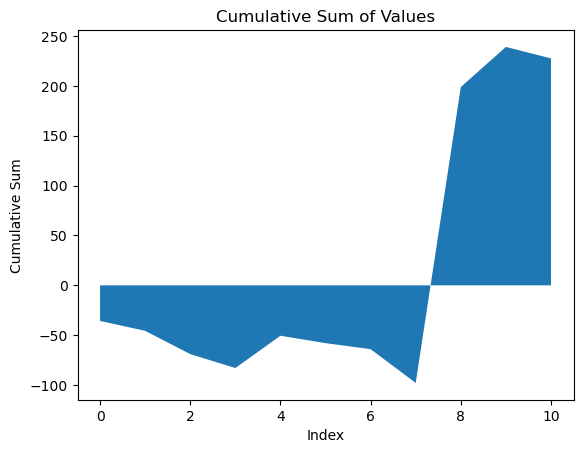

[-35.70184999999999, -45.66889999999999, -68.97659999999999, -82.95699999999997, -50.557299999999984, -58.00029999999997, -64.03499999999997, -97.88955000000006, 198.88409999999988, 239.11494999999985, 227.59619999999984]


In [23]:
cumulative_values = []
cumulative_sum = 0
for value in agg_amts:
    cumulative_sum -= value
    cumulative_values.append(cumulative_sum)

plt.fill_between(range(len(cumulative_values)), cumulative_values, 0)

plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values')

plt.show()

print(cumulative_values)

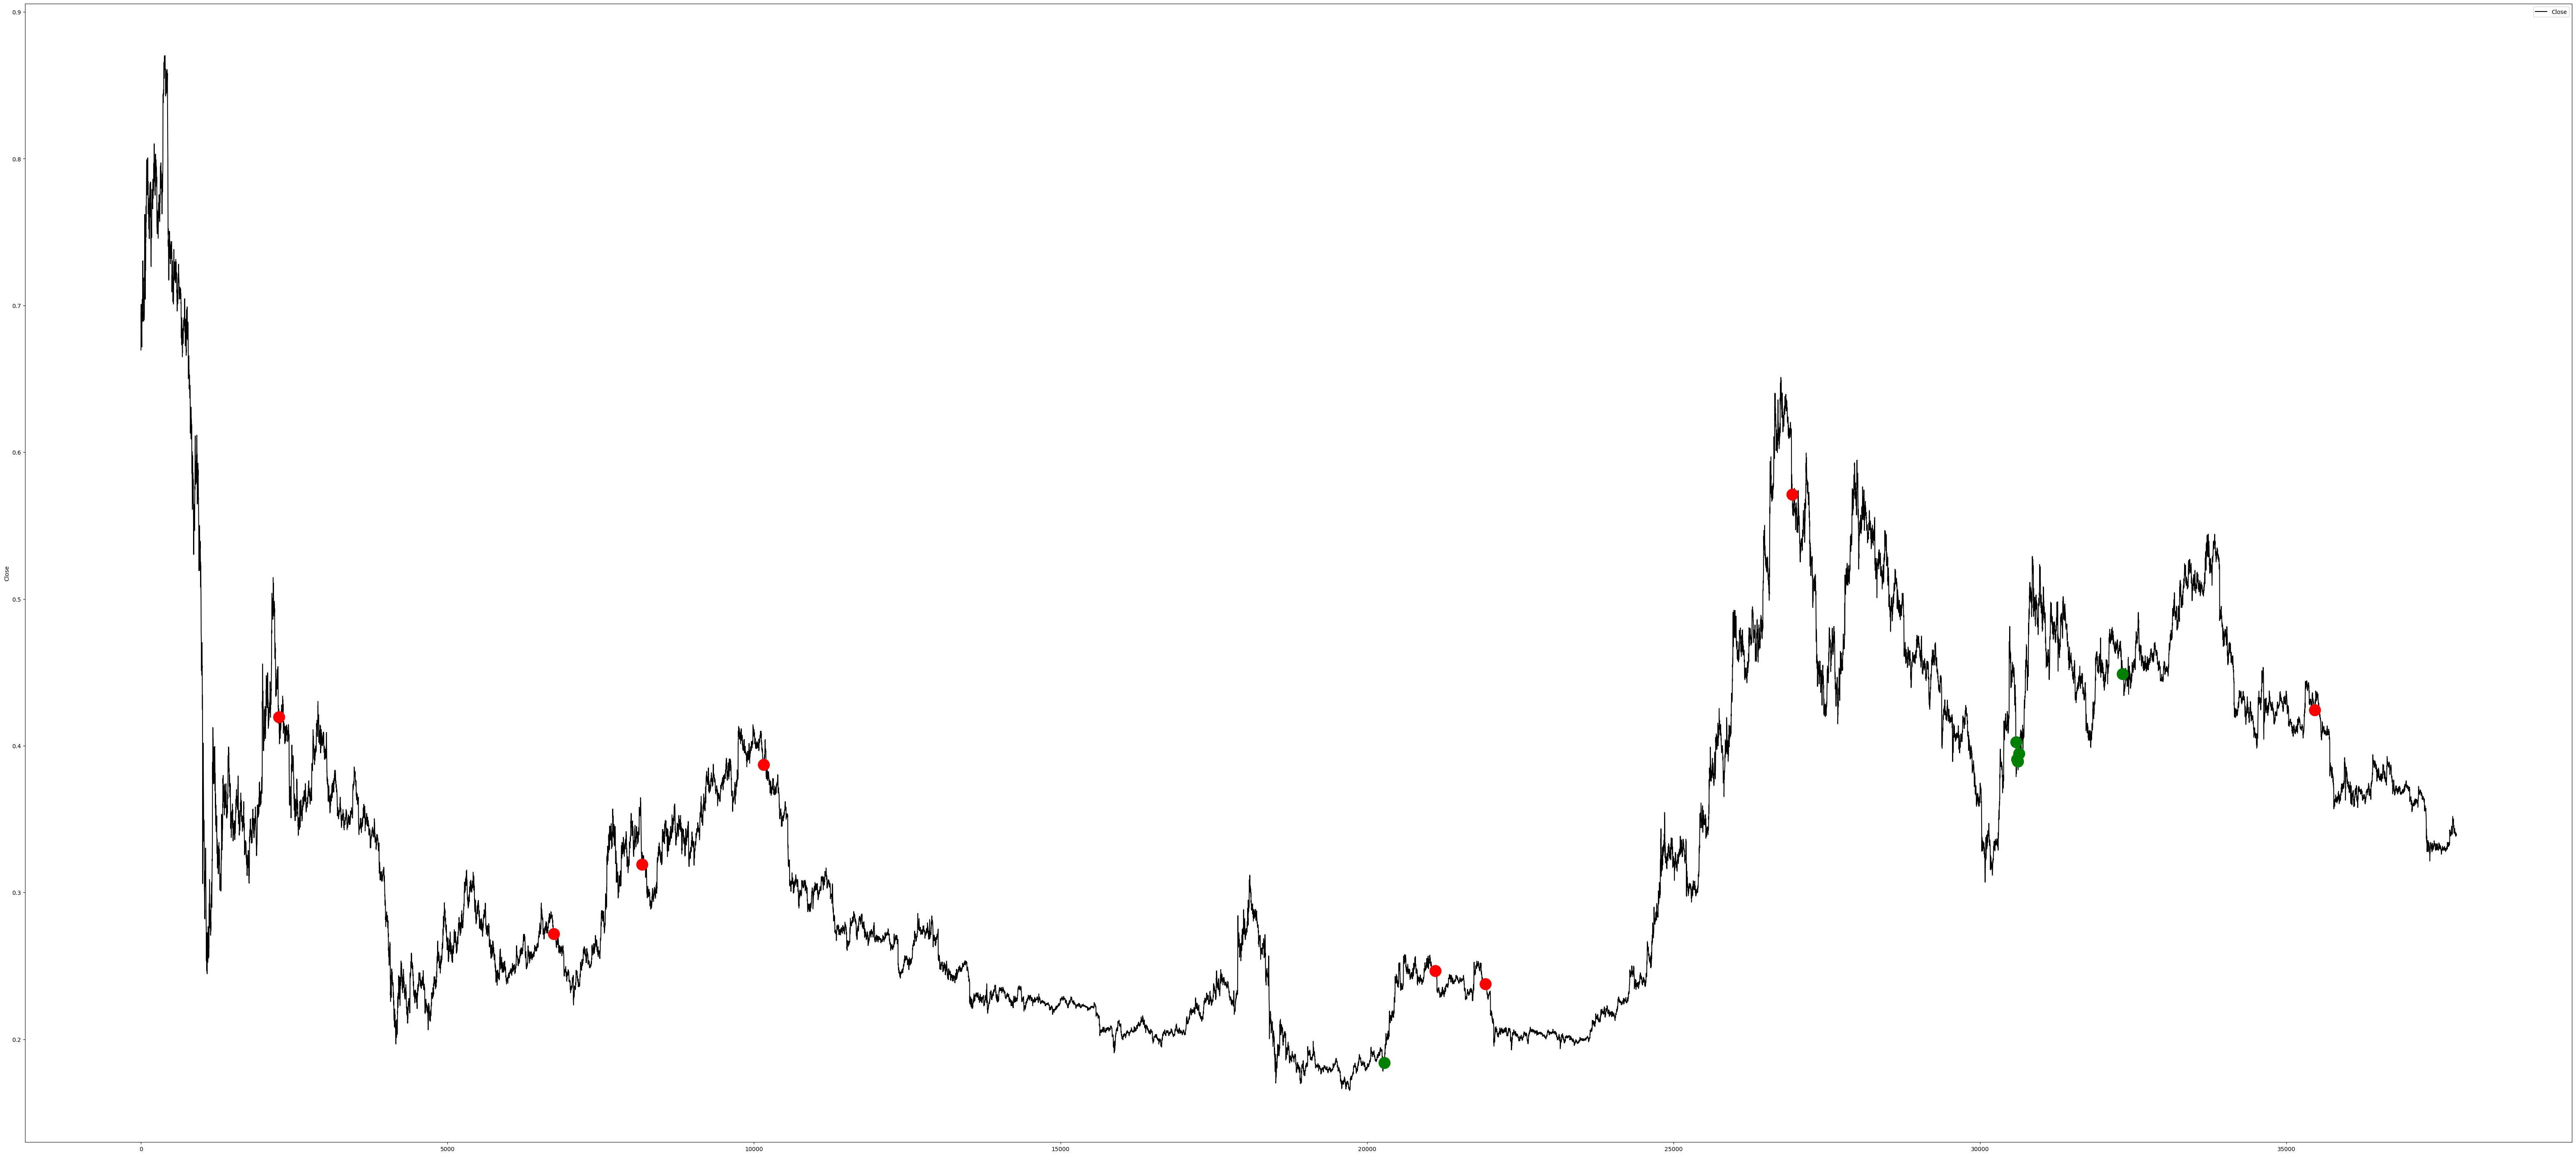

In [24]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位